In [58]:
!pip install pmdarima 


In [3]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8); # setting the figuresize 

from datetime import datetime, date #Library to deal with datetime columns

# time series analysis libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time series forecasting libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# model evaluation libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

In [4]:
df = pd.read_csv('Dataset Cement.csv') # loading the data 

In [5]:
df.head()

,Month,Demand_MT,Sales_MT,Unit_price,Total_price,Transportation Cost,Housing Interest Rate,GDP Construction
0,2015-01,5.91,5.71,390,2226.90,467.65,7.5,214180
1,2015-02,5.42,5.41,385,2082.85,416.57,8.1,214179
2,2015-03,4.82,4.75,380,1805.00,397.10,7.9,214181
3,2015-04,4.68,4.55,395,1797.25,377.42,8.5,218253
4,2015-05,4.69,4.56,400,1824.00,401.28,7.6,218252


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  96 non-null     object 
 1   Demand_MT              96 non-null     float64
 2   Sales_MT               96 non-null     float64
 3   Unit_price             96 non-null     int64  
 4   Total_price            96 non-null     float64
 5   Transportation Cost    96 non-null     float64
 6   Housing Interest Rate  96 non-null     float64
 7   GDP Construction       96 non-null     int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ KB


In [7]:
df.duplicated().sum()

0

In [8]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y %m') # converting year column to datetime format

In [9]:
df.set_index(['Month'], inplace=True) # changing index to datetime 

In [10]:
df.head()

,Demand_MT,Sales_MT,Unit_price,Total_price,Transportation Cost,Housing Interest Rate,GDP Construction
Month,,,,,,,
2015-01-01,5.91,5.71,390,2226.90,467.65,7.5,214180
2015-02-01,5.42,5.41,385,2082.85,416.57,8.1,214179
2015-03-01,4.82,4.75,380,1805.00,397.10,7.9,214181
2015-04-01,4.68,4.55,395,1797.25,377.42,8.5,218253
2015-05-01,4.69,4.56,400,1824.00,401.28,7.6,218252


In [11]:
df.index.min(), df.index.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

In [59]:
# checking if data is continues
if (df.index.max() - df.index.min() == 95): 
    print('Data Is Continuous')

In [13]:
df.index.freq='MS' # setting the data frequency to year


           1. No null values
           2. length of df is 96
           3. No duplicate values present 
           
   

# Time Series Analysis

Let's visualize the data

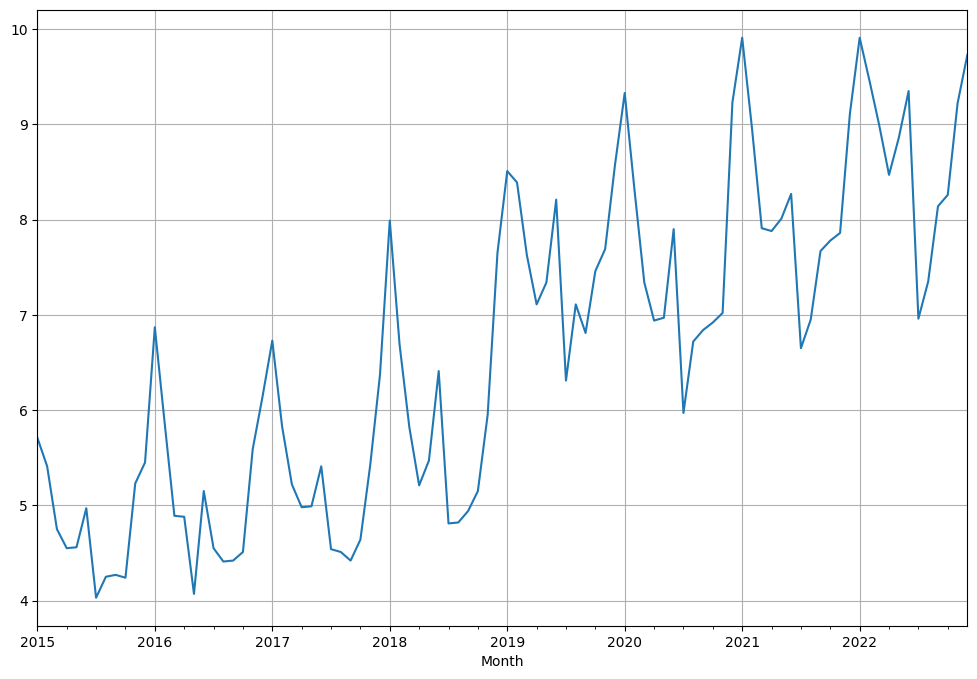

In [14]:
df["Sales_MT"].plot(grid=True);

the data is showing seasonality along with trend

In [15]:
# Train test split the dataset
train_df = df.head(84)
test_df = df.tail(12)

**Time Series Decomposition:**   
A time series is usually composed of the following components:
   > **1) Trend :** This component usually is increasing, decreasing, or constant.  
   > **2) Seasonality :** This is the periodic behavior of the time series that occurs within a year.   
   > **3) Residual :** This is what remains of the time series after the trend and seasonality are removed.  

The basic approach to seasonal decomposition splits the time series into above components.

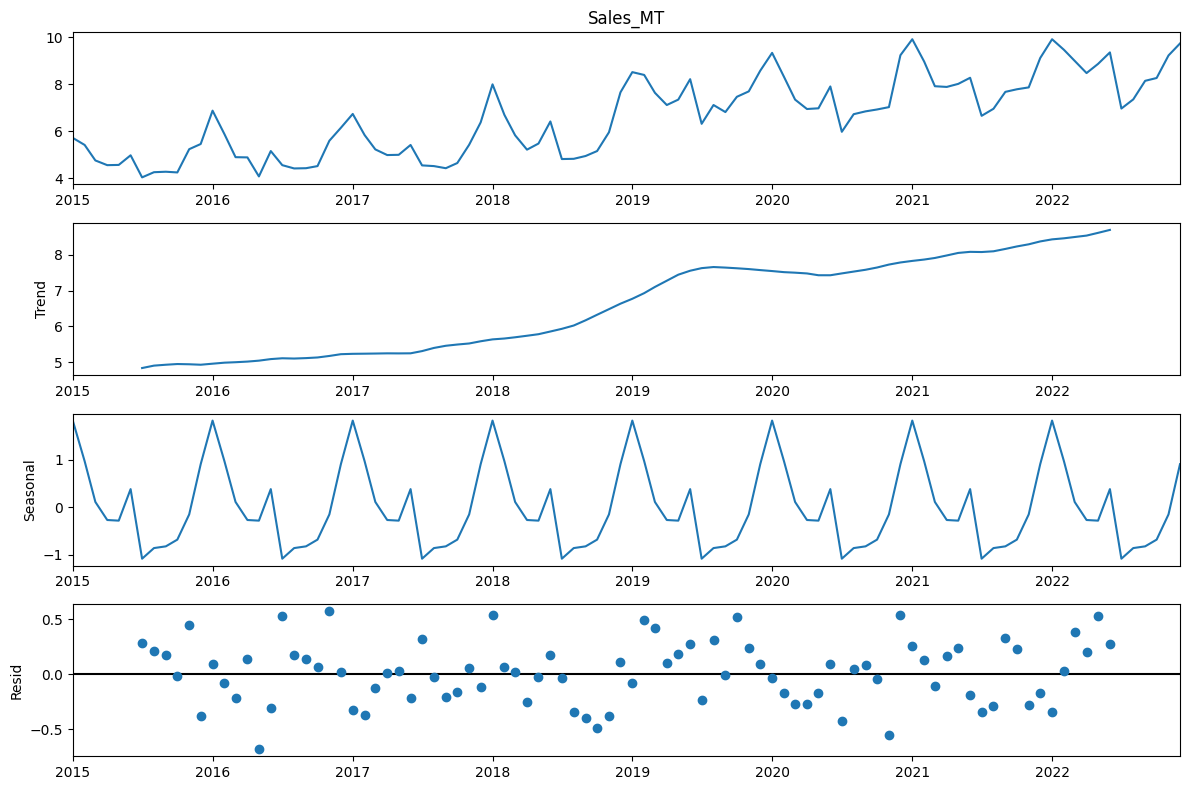

In [16]:
decompose_add = seasonal_decompose(df['Sales_MT'])
decompose_add.plot();

**Stationary Time Series :**   
A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. 

Sign of obvious trends, seasonality, or other systematic structures in the series are indicators of a non-stationary series. A more accurate method would be to use a statistical test, such as the Dickey-Fuller test.

**ADFuller Test:**  
If Test statistic < Critical Value and p-value < 0.05 – then series is stationary

In [17]:
# functon for adf test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)
    
# calling adf function and passing series
adf_test(df.Sales_MT)

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                  0.197414
p-value                         0.972116
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64



   The p-value obtained is greater than significance level of 0.05 
    so data is not stationar
         

# Differencing 
Differencing is a method of transforming a time series dataset. Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.

Depending on the number of diferencing required to make series stationary,we get value of 'd'. Which is a required parameter in ARIMA model

In [24]:
diff_df['Sales_MT'] = df['Sales_MT'].diff() #first differencing for stationarity
diff_df['Sales_MT'].head()

Month
2015-01-01     NaN
2015-02-01   -0.30
2015-03-01   -0.66
2015-04-01   -0.20
2015-05-01    0.01
Freq: MS, Name: Sales_MT, dtype: float64

In [25]:
diff_df['Sales_MT'].dropna(inplace=True) # depending on your differenced order you might have 1,2 or 3 null values, remove those

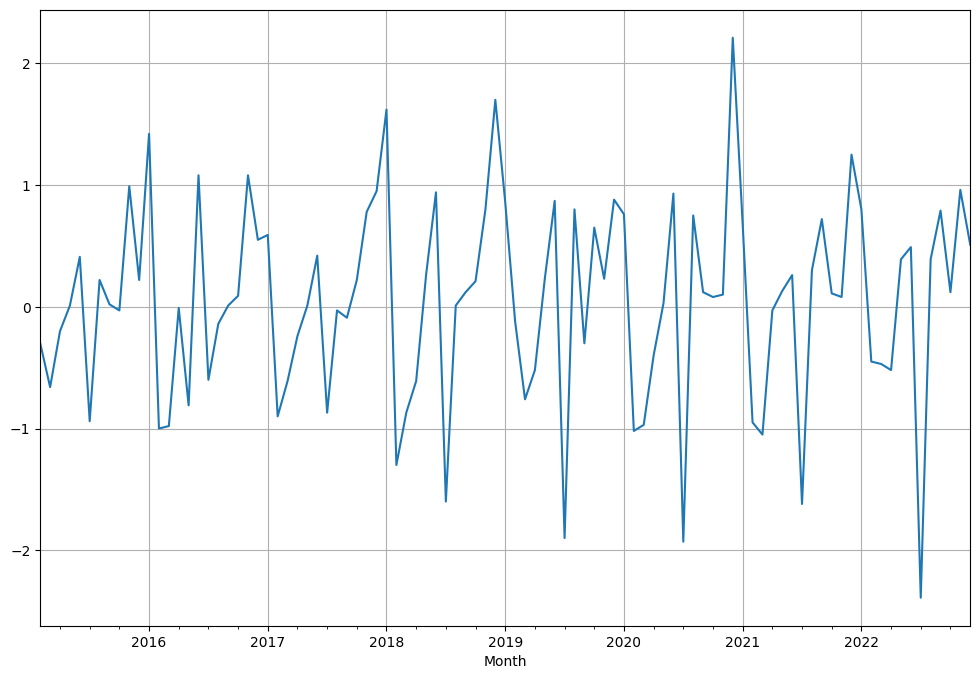

In [26]:
diff_df["Sales_MT"].plot(grid=True);

In [27]:
# call the adf_test function and pass differenced series
adf_test(diff_df['Sales_MT'])

Results of Dickey-Fuller Test:
----------------------------------------------
Test Statistic                 -3.244780
p-value                         0.017535
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64



           The p-value obtained is less than significance level of 0.05  
    So data is stationary

##Autocorrelation and Partial Autocorrelation Function 
Autocorrelation and partial autocorrelation are plots that graphically summarize the impact of observations at prior timesteps on the observations we are trying to predict.

##ACF plot gives the q value and PACF gives the p value 
Look for tail of pattern in either ACF or PACF. If tail is crossing the blue region then it will give us potential p and q values.

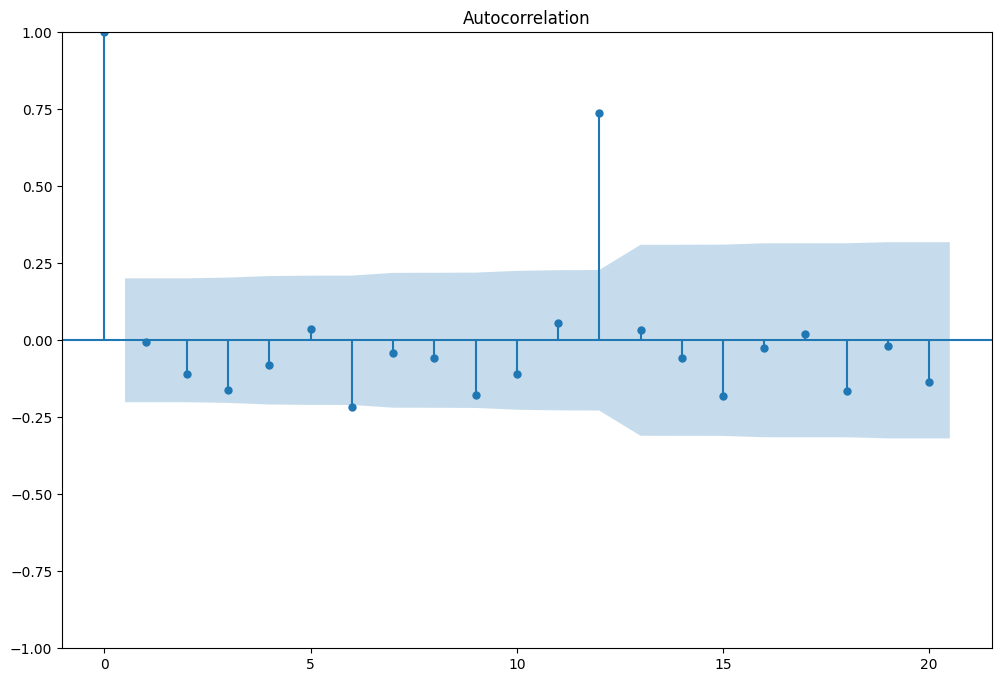

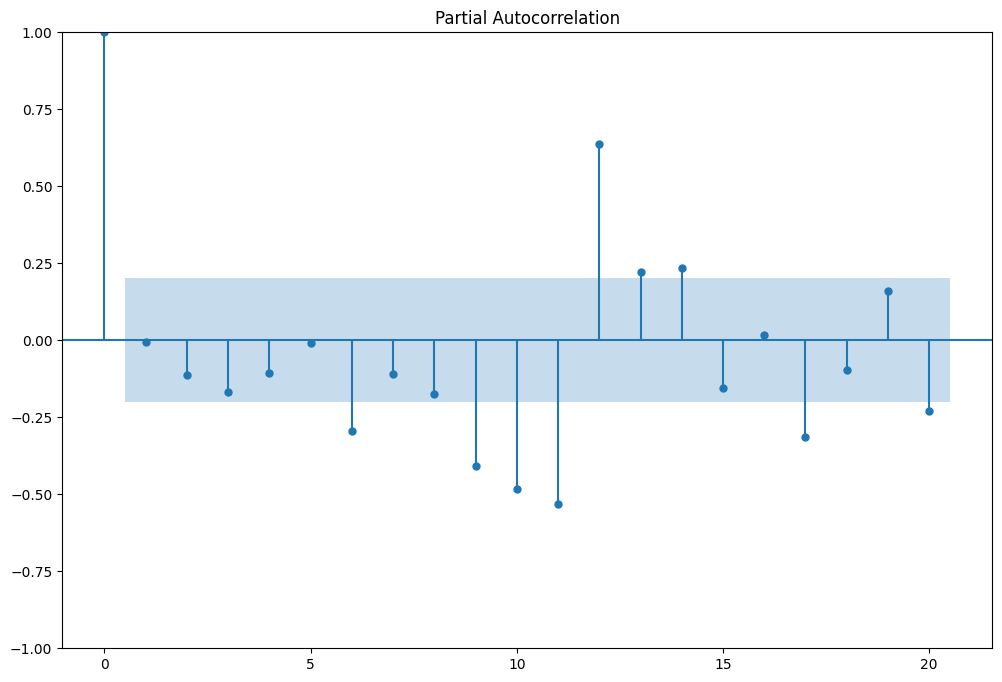

In [28]:
# if the series is not stationary then make sure to pass differenced series instead of original series
plot_acf(diff_df["Sales_MT"]);
plot_pacf(diff_df['Sales_MT']);


           1.From ACF plot we can see that q values can be 6, 12 
           2.From PACF plot we can see that p values can be 6,9,10,11,12,17 & 20 
        
   

# Time Series Forecasting
 

##Exponential Smoothing 
Exponential smoothing is a time series forecasting method for univariate data. There are three main types of exponential smoothing time series forecasting methods.
A simple method that assumes no systematic structure, an extension that explicitly handles trends, and the most advanced approach that add support for seasonality.

# Single Exponential Smoothing


In [29]:
single_exp = SimpleExpSmoothing(train_df['Sales_MT']).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(12)

<AxesSubplot: xlabel='Month'>

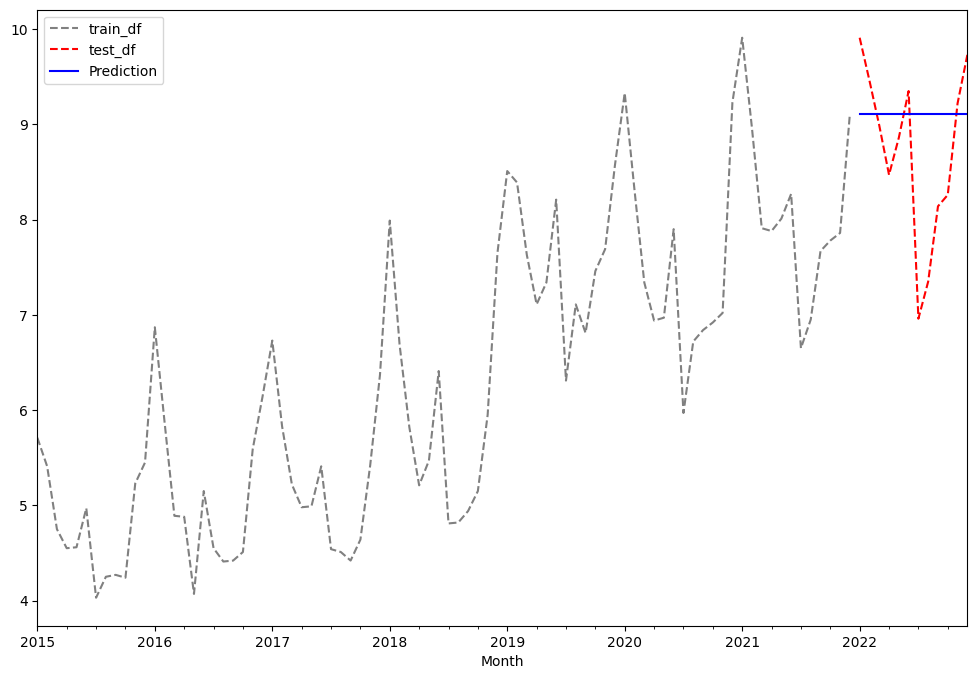

In [30]:
train_df['Sales_MT'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Sales_MT'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [31]:
print('Train RMSE:',mean_squared_error(train_df['Sales_MT'], single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['Sales_MT'], single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['Sales_MT'], single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['Sales_MT'], single_exp_test_pred))

Train RMSE: 0.8101927693711588
Test RMSE: 0.9589165781394957
Train MAPE: 0.09769306448239512
Test MAPE: 0.09205476878166517


# Holt-Winters Exponential Smoothing.

In [32]:
hw_model = ExponentialSmoothing(train_df['Sales_MT'],
                          trend    ='add',
                          initialization_method='heuristic',
                          seasonal = "add", 
                          seasonal_periods=12, 
                          damped_trend=True).fit()
hw_train_pred =  hw_model.fittedvalues
hw_test_pred =  hw_model.forecast(12)

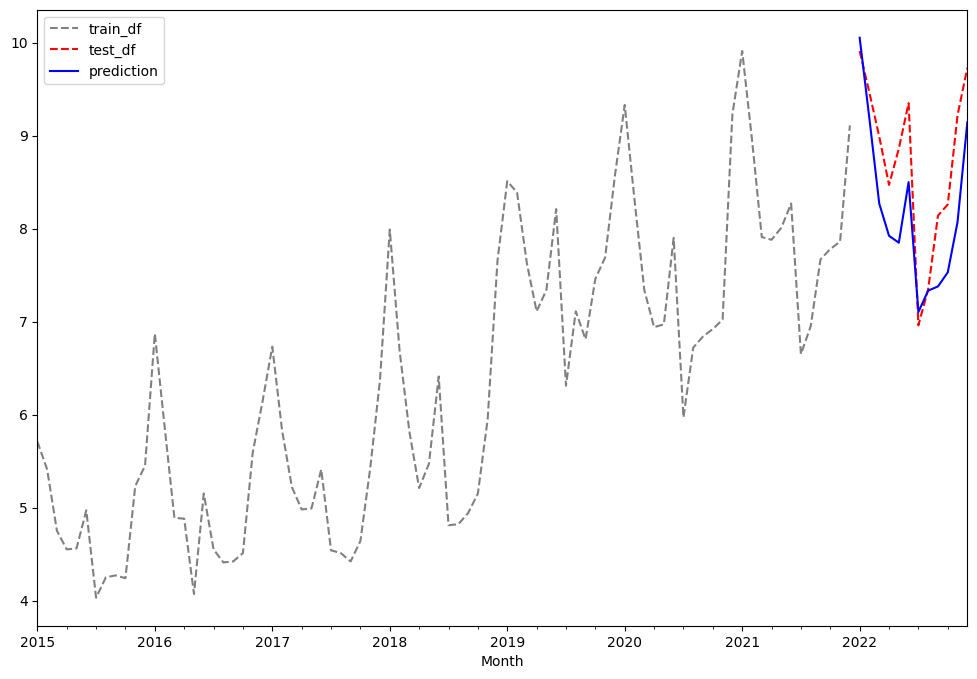

In [33]:
train_df['Sales_MT'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Sales_MT'].plot(style='--', color='r', legend=True, label='test_df')
hw_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [34]:
print('Train RMSE:',mean_squared_error(train_df['Sales_MT'], hw_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['Sales_MT'], hw_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['Sales_MT'], hw_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['Sales_MT'], hw_test_pred))

Train RMSE: 0.33203367921904636
Test RMSE: 0.6744284664397415
Train MAPE: 0.04177342904779143
Test MAPE: 0.0652938280916584


# Arima
 

A popular and widely used statistical method for time series forecasting is the ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. The parameters of the ARIMA model are defined as follows:

p : The number of lag observations included in the model, also called the lag order.   
d: The number of times that the raw observations are differenced, also called the degree of differencing.   
q : The size of the moving average window, also called the order of moving average.

In [35]:
# we got the p,d,q value from time series analysis
ar = ARIMA(train_df['Sales_MT'], order=(6,1,6)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(12)

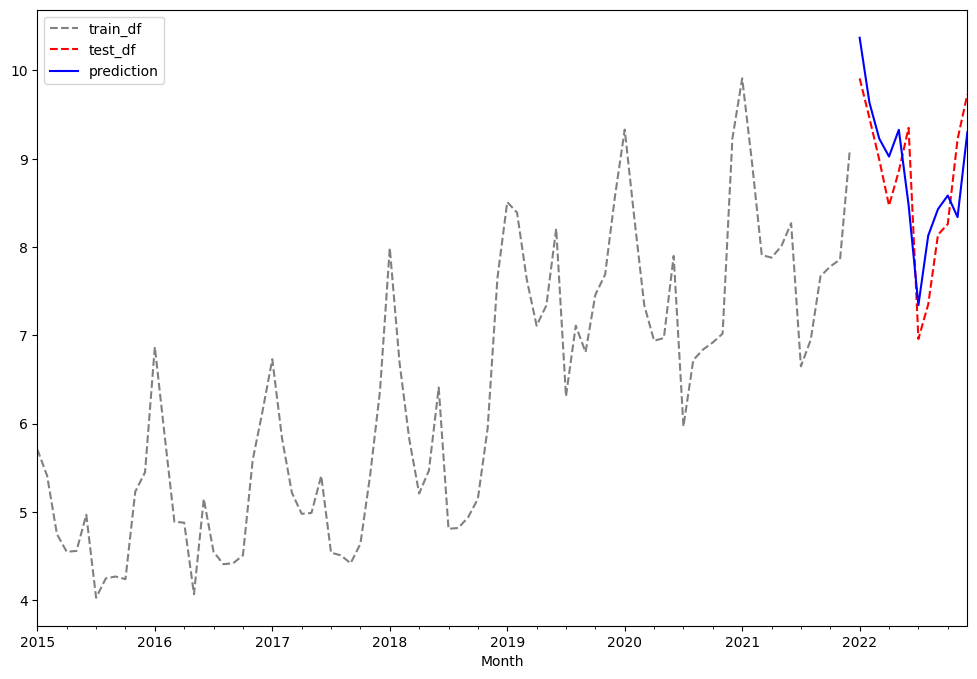

In [36]:
train_df['Sales_MT'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Sales_MT'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [37]:
print('Train RMSE:',mean_squared_error(train_df['Sales_MT'], ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['Sales_MT'], ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['Sales_MT'], ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['Sales_MT'], ar_test_pred))

Train RMSE: 0.8775346368631015
Test RMSE: 0.5393721587085125
Train MAPE: 0.09049005219224768
Test MAPE: 0.056536787539673054


# Grid Search p,d,q Values


From acf and pacf we got different potenstial p,q values. Lets use grid search to find the best pair out of them

In [38]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order):
    # prepare training dataset
    train_df = df.head(84)
    test_df = df.tail(12)
    # make predictions
    model = ARIMA(train_df['Sales_MT'], order=arima_order).fit()
    model_pred = model.forecast(12)
    rmse = (mean_squared_error(test_df['Sales_MT'], model_pred)**0.5)
    return rmse

In [39]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for q in q_values:
                order = (p,1,q)
                try:
                    rmse = evaluate_arima_model(order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [44]:
# evaluate parameters
p_values = [6,9,10,11,12]
q_values = [6,12]
evaluate_models(df['Sales_MT'].values, p_values, q_values)

Best ARIMA(6, 1, 6) RMSE=0.539


In [49]:
arima = ARIMA(train_df['Sales_MT'], order=(6,1,6)).fit()
arima_train_pred = arima.predict()
arima_test_pred = arima.forecast(12)

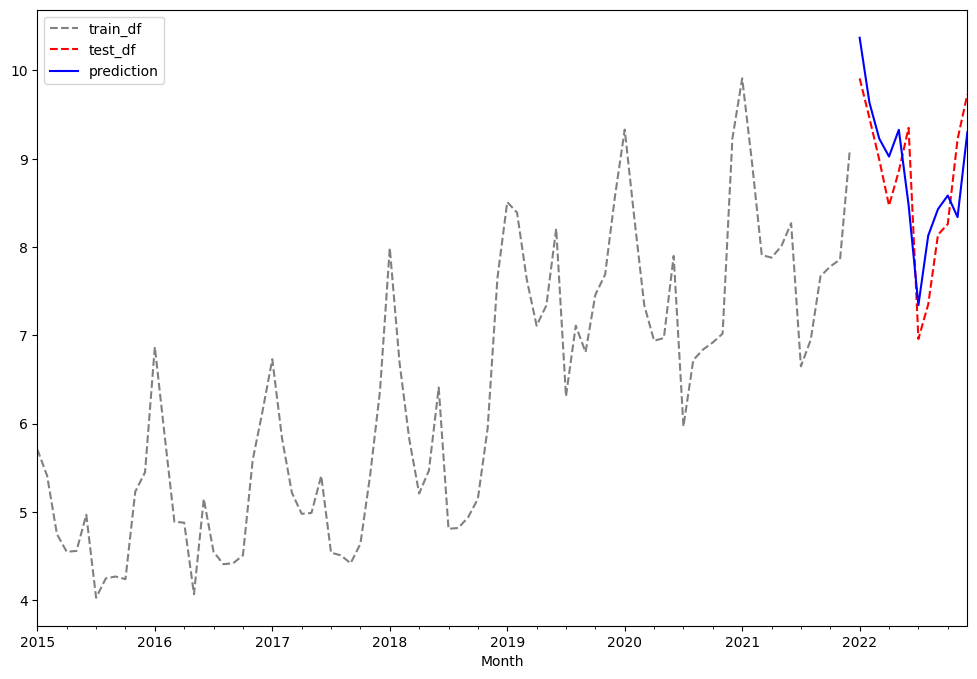

In [50]:
train_df['Sales_MT'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Sales_MT'].plot(style='--', color='r', legend=True, label='test_df')
arima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [51]:
print('Train RMSE:',mean_squared_error(train_df['Sales_MT'], arima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['Sales_MT'], arima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['Sales_MT'], arima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['Sales_MT'], arima_test_pred))

Train RMSE: 0.8775346368631015
Test RMSE: 0.5393721587085125
Train MAPE: 0.09049005219224768
Test MAPE: 0.056536787539673054


# Auto Arima


In [52]:
auto_arima(df['Sales_MT'], m=12, max_order= None, max_p=6, max_q=6, max_d=1,max_P=6, max_Q=6, max_D=2, maxiter=50, alpha=0.05, n_jobs=-1,information_criterion='aic', out_of_sample_size=30).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -42.803
Date:                            Sat, 04 Mar 2023   AIC                             95.606
Time:                                    13:33:27   BIC                            107.761
Sample:                                         0   HQIC                           100.492
                                             - 96                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0771      0.050      1.526      0.127      -0.022       0.176
ar.L1          0.8741      0.080     10.882      0.000       0.717       1.032
ma.L1         -0.3278      0.152     -2.160      0.031      -0.625      -0.030
ma.S.L12      -0.6866      0.116     -5.927      0.000      -0.914      -0.460
sigma2         0.1558      0.030      5.138      0.000       0.096       0.215
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.70
Prob(Q):                              0.84   Prob(JB):                         0.26
Heteroskedasticity (H):               1.45   Skew:                             0.42
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
# pass the order and seasonal order values we got from auto arima
sarima = SARIMAX(train_df['Sales_MT'], order=(1,0,1), seasonal_order=(0,1,1,12)).fit()
sarima_train_pred = sarima.predict()
sarima_test_pred = sarima.forecast(12)

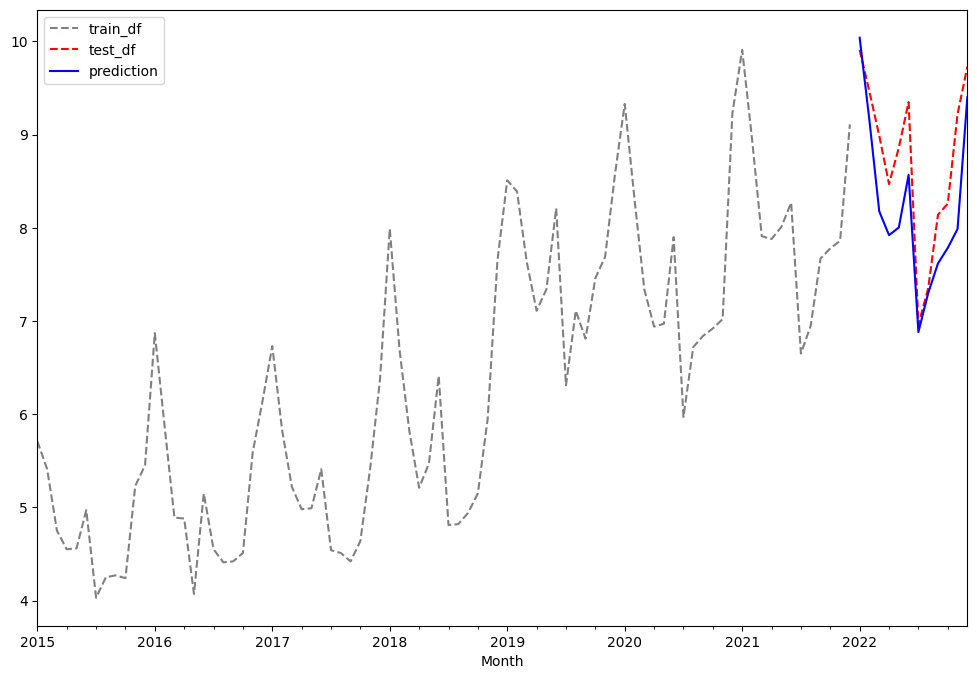

In [54]:
train_df['Sales_MT'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['Sales_MT'].plot(style='--', color='r', legend=True, label='test_df')
sarima_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [55]:
print('Train RMSE:',mean_squared_error(train_df['Sales_MT'], sarima_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_df['Sales_MT'], sarima_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_df['Sales_MT'], sarima_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_df['Sales_MT'], sarima_test_pred))

Train RMSE: 1.8616817647532982
Test RMSE: 0.6158644899332215
Train MAPE: 0.18704979500406457
Test MAPE: 0.05739012167750756


# Model Comparision


In [64]:
comparision_df = pd.DataFrame(data=[['Single exp smoothing', 0.9589 , 0.0920],
                           ['Holt winter exp smoothing', 0.6744,  0.0652],
                           ['ARIMA(6,1,6)', 0.5393, 0.05653],
                           ['SARIMA(1,0,1)(0,1,1,12)', 0.6158, 0.05739]],columns=['Model','RMSE','MAPE'])

comparision_df.set_index('Model', inplace=True)

In [65]:
comparision_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
"ARIMA(6,1,6)",0.5393,0.05653
"SARIMA(1,0,1)(0,1,1,12)",0.6158,0.05739
Holt winter exp smoothing,0.6744,0.06520
Single exp smoothing,0.9589,0.09200



           We can clearly see that ARIMA model is performing best among all other models 
           

Now let's train the best performing model (ARIMA) on complete data

In [66]:
ar = ARIMA(df['Sales_MT'], order=(6,1,6)).fit()
ar_pred = ar.forecast(24)


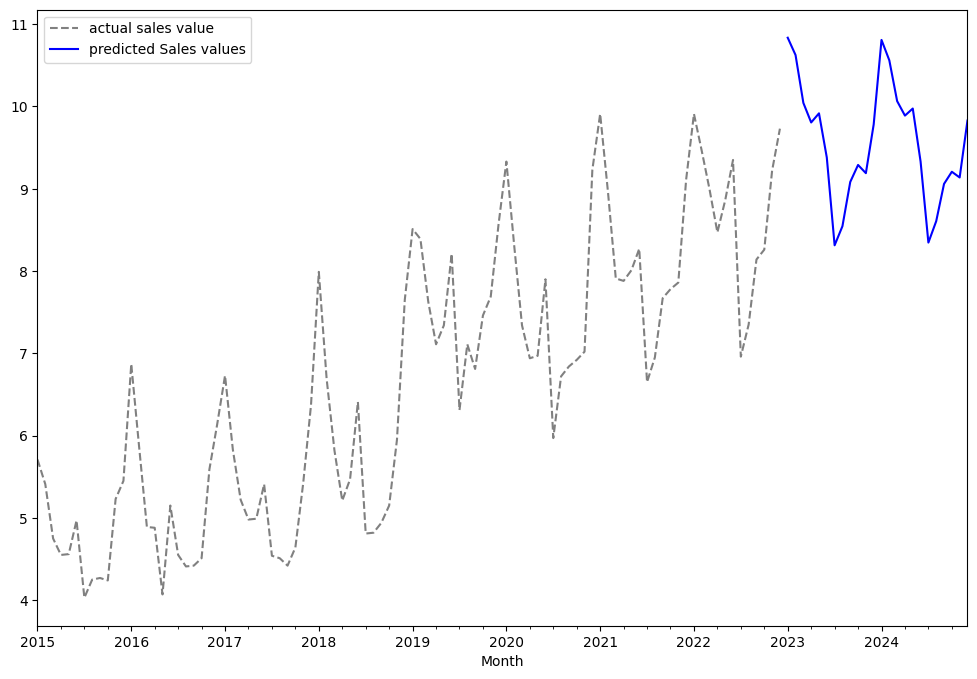

In [67]:
df['Sales_MT'].plot(style='--', color='gray', legend=True, label='actual sales value')
ar_pred.plot(color='b', legend=True, label='predicted Sales values')
plt.show()